## Data Exploration

In this step, we will explore the datasets and do a little preprocessing.

# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.metrics import classification_report # for generating a classification report of model
import warnings
warnings.filterwarnings("ignore")

# Dataset Information

In [3]:
dataset_train=pd.read_csv('../datasets/KDDTrain+.txt',header=None)

In [4]:
dataset_test=pd.read_csv('../datasets/KDDTest+.txt',header=None)

# Sample view of the training dataset

In [5]:
dataset_train.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


# Sample view of the test dataset

In [6]:
dataset_test.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


# Columns Name of Training and Test dataset

In [7]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]


# Shape of Training and Test

In [8]:
print("Shape of Training Dataset:", dataset_train.shape)
print("Shape of Testing Dataset:", dataset_test.shape)

Shape of Training Dataset: (125973, 43)
Shape of Testing Dataset: (22544, 43)


# Columns Assignement

In [9]:
# Assigning attribute name to dataset
dataset_train.columns = col_names
dataset_test.columns = col_names

# Label of training and test dataset

In [10]:
#label distribution of Training set and testing set
print('Label distribution Training set:')
print(dataset_train['label'].value_counts())
print()
print('Label distribution Test set:')
print(dataset_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Data preprocessing

One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features. Requirement for One-Hot-encoding: "The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range [0, n_values)."

Therefore the features first need to be transformed with LabelEncoder, to transform every category to a number


## Drop Useless Column

In [11]:
dataset_train.drop(['difficulty_level'],axis=1,inplace=True)
dataset_test.drop(['difficulty_level'],axis=1,inplace=True)

## Changing attack labels to their respective attack class

Within the data set exists 4 different classes of attacks: Denial of Service (DoS), Probe, User to Root(U2R), and Remote to Local (R2L). The dataset contains subclasses of these attacks which we will be replacing with the main class of attacks.

The sub classes of attacks are:

| Dos | R2L | Probe | U2R |
| --- | --- | --- | --- |
| back | ftp_write | ipsweep |  buffer_overflow |
| land | guess_passwd | mscan |  loadmodule |
| neptune | httptunnel | nmap |  perl |
| mailbomb | imap | portsweep |  ps |
| pod | multihop | saint |  rootkit |
| processtable | named | satan |  sqlattack |
| smurf | phf |      | xterm | |
| teardrop | sendmail |      | |
| udpstorm | snmpgetattack |      | |
| worm |   snmpguess |      | |
|       | spy |      | |
|       | warezclient |      | |
|       | warezmaster |      | |
|       | xlock |      | |
|       | xsnoop |      | |



In [12]:
def change_label_of(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)


change_label_of(dataset_train)
change_label_of(dataset_test)

In [13]:
#label distribution of Training set and testing set after relabeling
print('Label distribution Training set:')
print(dataset_train['label'].value_counts())
print()
print('Label distribution Test set:')
print(dataset_test['label'].value_counts())

Label distribution Training set:
normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: label, dtype: int64

Label distribution Test set:
normal    9711
Dos       7460
R2L       2885
Probe     2421
U2R         67
Name: label, dtype: int64


# Identify categorical features

In [14]:
# explore categorical features
print('Training set:')
for col_name in dataset_train.columns:
    if dataset_train[col_name].dtypes == 'object' :
        unique_cat = len(dataset_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 5 categories


In [15]:
# Test set
print('Test set:')
for col_name in dataset_test.columns:
    if dataset_test[col_name].dtypes == 'object' :
        unique_cat = len(dataset_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 5 categories


# Encoding categorical features


### Insert categorical features into a 2D numpy array


In [16]:
categorical_columns=['protocol_type', 'service', 'flag']
label = ["label"]

# seperate categorical data from non-categorical data and labels
categorical_train_data = dataset_train[categorical_columns]
non_categorical_train_data = dataset_train.drop(categorical_columns+label, axis=1)

categorical_test_data = dataset_test[categorical_columns]
non_categorical_test_data = dataset_test.drop(categorical_columns+label, axis=1)

# Separate label from dataset
label_train_data = dataset_train['label']
label_test_data = dataset_test['label']

# visualize categorical data
categorical_train_data.head()


,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [17]:

# convert categorical data to numeric using one-hot encoding
categorical_train_data_encoded = pd.get_dummies(categorical_train_data)
categorical_test_data_encoded = pd.get_dummies(categorical_test_data)

# visualize encoded categorical data
categorical_train_data_encoded.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Dataset Normalization
We will use MinMaxScaler to normalize the non-categorical features.

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Function to normalize the dataset
def normalization(df):
  for i in df.columns:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.fit_transform(arr.reshape(len(arr),1))
  return df


# Normalize the training set
non_categorical_train_data = normalization(non_categorical_train_data)

# Normalize the test set
non_categorical_test_data = normalization(non_categorical_test_data)

non_categorical_train_data.head()



,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Feature Selection with Principal Component Analysis (PCA)

We will now perform PCA on the non-catergorical dataset to reduce the dimensionality of the dataset.

In [19]:
#  feature selection using pca
from sklearn.decomposition import PCA
# We choose the minimum number of principal components 
# such that 95% of the variance is retained.
pca = PCA(.95)

pca.fit(non_categorical_train_data)

non_categorical_train_data_pca = pca.transform(non_categorical_train_data)

non_categorical_test_data_pca = pca.transform(non_categorical_test_data)

non_categorical_train_data_pca = pd.DataFrame(data = non_categorical_train_data_pca,
                                                columns = [f"component_{i}" for i in range(1, pca.n_components_+1)])

non_categorical_test_data_pca = pd.DataFrame(data = non_categorical_test_data_pca,
                                                columns = [f"component_{i}" for i in range(1, pca.n_components_+1)])

non_categorical_test_data_pca.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9
0,0.313018,2.020621,-0.442366,0.072597,-0.104484,0.107737,0.111945,-0.090157,-0.273068
1,0.326211,2.029053,-0.426989,0.121844,-0.044106,0.123757,0.039911,-0.122391,-0.180570
2,-0.490085,0.087332,0.682215,-0.311877,0.117065,-0.203881,-0.068494,-0.167778,0.090351
3,-0.781735,-0.002797,1.439756,0.139472,-0.249855,0.498271,0.029984,0.079584,-0.101546
4,-0.426118,1.282375,0.336694,0.594071,-0.406471,0.414376,-0.242383,-0.415657,0.045041


In [20]:
# check number of components selected
print("number of features selected: ", pca.n_components_)

number of features selected:  9


# Encoding the Label

In [21]:
# create a new column in the label dataset with the ecoded labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

encoded_train_labels = label_encoder.fit_transform(label_train_data)
encoded_test_labels = label_encoder.fit_transform(label_test_data)

label_classes = label_encoder.classes_


# Join encoded categorical dataframe with the non-categorical dataframe

In [22]:
categorical_test_data_encoded
categorical_train_data_encoded

non_categorical_test_data_pca
non_categorical_train_data_pca

# concatenate the categorical and non-categorical data and labels
train_data = pd.concat([categorical_train_data_encoded, non_categorical_train_data_pca], axis=1)
test_data = pd.concat([categorical_test_data_encoded, non_categorical_test_data_pca], axis=1)

train_data["target"] = encoded_train_labels
test_data["target"] = encoded_test_labels
test_data.head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,target
0,0,1,0,0,0,0,0,0,0,0,...,0.313018,2.020621,-0.442366,0.072597,-0.104484,0.107737,0.111945,-0.090157,-0.273068,0
1,0,1,0,0,0,0,0,0,0,0,...,0.326211,2.029053,-0.426989,0.121844,-0.044106,0.123757,0.039911,-0.122391,-0.180570,0
2,0,1,0,0,0,0,0,0,0,0,...,-0.490085,0.087332,0.682215,-0.311877,0.117065,-0.203881,-0.068494,-0.167778,0.090351,4
3,1,0,0,0,0,0,0,0,0,0,...,-0.781735,-0.002797,1.439756,0.139472,-0.249855,0.498271,0.029984,0.079584,-0.101546,1
4,0,1,0,0,0,0,0,0,0,0,...,-0.426118,1.282375,0.336694,0.594071,-0.406471,0.414376,-0.242383,-0.415657,0.045041,1


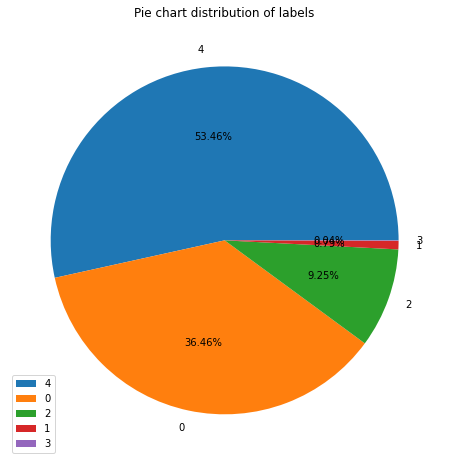

In [23]:
plt.figure(figsize=(8,8))
plt.pie(train_data.target.value_counts(),labels=train_data.target.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of labels')
plt.legend()
plt.show()

# Building the models

### Here, we will build 3 models:
### 1. Linear SVM
### 2. K-Nearest Neighbors
### 3. AdaBoost Ensemble Model with Linear SVM and K-Nearest Neighbors

In [25]:
# Setting Training and Testing variables

x_train = train_data.drop(['target'],axis=1).to_numpy()
y_train = train_data.target
x_test = test_data.drop(['target'],axis=1).to_numpy()
y_test = test_data.target


# Linear Support Vector Machine (SVM)
### Linear SVM is a classification algorithm that uses a linear decision boundary to classify data.

In [26]:
from sklearn.svm import SVC

svm = SVC(kernel='linear',gamma='auto')
svm.fit(x_train,y_train) # training model on training dataset

KeyboardInterrupt: 